In [9]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [10]:
# Carregar os dados de um diretório
directory = "C:/Users/Lucas Teixeira/AP-Emulators/Generated_Data_100K/ModelA"  # Substitua pelo seu diretório
Ns = 1000  # Número máximo de amostras a carregar
X = pd.read_csv(os.path.join(directory, "X.csv")).iloc[0:Ns]
Y = pd.read_csv(os.path.join(directory, "Y.csv")).iloc[0:Ns]
print(f"Carregado X com forma: {X.shape}")
print(f"Carregado Y com forma: {Y.shape}")

# Dividir os dados em treino e validação
test_size = 0.5
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)
print(f"Treino X: {X_train.shape}, Validação X: {X_val.shape}")
print(f"Treino Y: {Y_train.shape}, Validação Y: {Y_val.shape}")

Carregado X com forma: (1000, 3)
Carregado Y com forma: (1000, 5)
Treino X: (500, 3), Validação X: (500, 3)
Treino Y: (500, 5), Validação Y: (500, 5)


In [11]:
# Verificar se todas as variáveis são DataFrames
if isinstance(X_train, pd.DataFrame) and isinstance(X_val, pd.DataFrame) and isinstance(Y_train, pd.DataFrame) and isinstance(Y_val, pd.DataFrame):
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
    Y_val = torch.tensor(Y_val.values, dtype=torch.float32) 


In [12]:
if torch.cuda.is_available():
    X_train, Y_train, X_val, Y_val = X_train.cuda(), Y_train.cuda(), X_val.cuda(), Y_val.cuda()

In [13]:
# Now define the MultitaskGPModel and the likelihood
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, Y_train, likelihood):
        super(MultitaskGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=5
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=5, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [14]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5) 
model = MultitaskGPModel(X_train, Y_train, likelihood)

In [15]:
likelihood = likelihood.cuda()
model = model.cuda()

In [16]:
# Define the number of iterations for training
training_iterations = 100

# Set model and likelihood to training mode
model.train()
likelihood.train()

# Initialize the Adam optimizer (this includes model and likelihood parameters)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the Marginal Log Likelihood (MLL) loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Start the training loop
for i in range(training_iterations):
    optimizer.zero_grad()  # Zero the gradients before backpropagation
    
    # Perform a forward pass of the model (get the output)
    output = model(X_train)
    
    # Compute the negative marginal log likelihood loss
    loss = -mll(output, Y_train)
    
    # Perform backpropagation to compute gradients
    loss.backward()
    
    # Print the loss every iteration
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f}')
    
    # Step the optimizer (update model parameters)
    optimizer.step()


Iter 1/100 - Loss: 23.590
Iter 2/100 - Loss: 20.334
Iter 3/100 - Loss: 17.509
Iter 4/100 - Loss: 15.101
Iter 5/100 - Loss: 13.064
Iter 6/100 - Loss: 11.368
Iter 7/100 - Loss: 9.976
Iter 8/100 - Loss: 8.835
Iter 9/100 - Loss: 7.896
Iter 10/100 - Loss: 7.124
Iter 11/100 - Loss: 6.495
Iter 12/100 - Loss: 5.984
Iter 13/100 - Loss: 5.566
Iter 14/100 - Loss: 5.220
Iter 15/100 - Loss: 4.931
Iter 16/100 - Loss: 4.688
Iter 17/100 - Loss: 4.483
Iter 18/100 - Loss: 4.310
Iter 19/100 - Loss: 4.163
Iter 20/100 - Loss: 4.036
Iter 21/100 - Loss: 3.925
Iter 22/100 - Loss: 3.829
Iter 23/100 - Loss: 3.743
Iter 24/100 - Loss: 3.667
Iter 25/100 - Loss: 3.599
Iter 26/100 - Loss: 3.536
Iter 27/100 - Loss: 3.478
Iter 28/100 - Loss: 3.425
Iter 29/100 - Loss: 3.375
Iter 30/100 - Loss: 3.328
Iter 31/100 - Loss: 3.285
Iter 32/100 - Loss: 3.244
Iter 33/100 - Loss: 3.205
Iter 34/100 - Loss: 3.167
Iter 35/100 - Loss: 3.131
Iter 36/100 - Loss: 3.097
Iter 37/100 - Loss: 3.064
Iter 38/100 - Loss: 3.032
Iter 39/100 - L

In [17]:
Y_val = Y_val.cpu()

# Set into eval mode
model.eval()
likelihood.eval()

# # Initialize plots
# f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_val))
    mean = predictions.mean.cpu()
    lower, upper = predictions.confidence_region()

c:\Users\Lucas Teixeira\anaconda3\envs\pytorchGPU\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


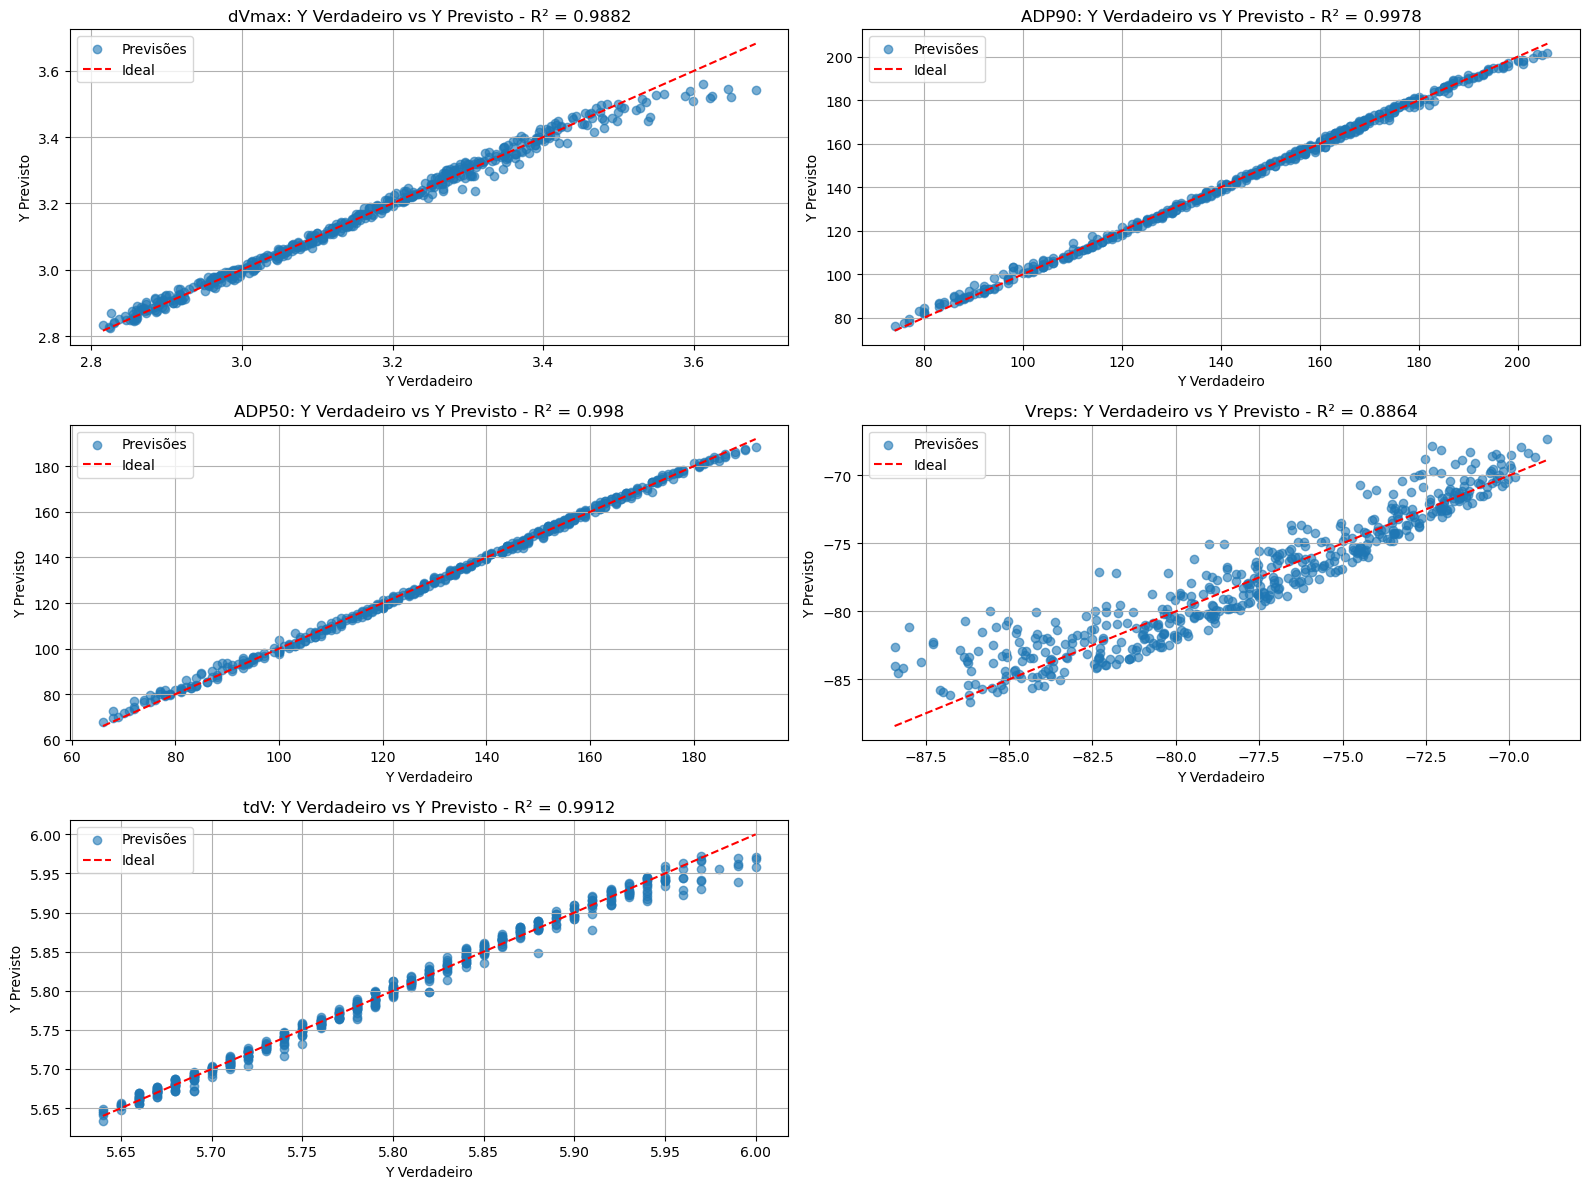

In [18]:
# Plotar Y verdadeiro vs Y previsto para cada QoI
# Configurar layout do mega plot

num_qois = len(Y.columns)
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, qoi in enumerate(Y.columns):
    ax = axes[i]
    ax.scatter(Y_val[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)], alpha=0.6, label="Previsões")
    ax.plot([Y_val[:, i].numpy().min(), Y_val[:, i].numpy().max()], [Y_val[:, i].numpy().min(), Y_val[:, i].numpy().max()], 
            color="red", linestyle="--", label="Ideal")
    r2 = r2_score(Y_val[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)])
    ax.set_title(f"{qoi}: Y Verdadeiro vs Y Previsto - R² = {round(r2,4)}")
    ax.set_xlabel("Y Verdadeiro")
    ax.set_ylabel("Y Previsto")
    ax.legend()
    ax.grid(True)

# Desativar eixos vazios, caso o número de QoIs seja menor que o total de subplots
for j in range(len(axes)):
    if j >= num_qois:
        axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f"{name}.jpg")